Los objetivos de este análisis son:
* Identificar el tipo de dato de todas la entidades en la tabla.
* Estadísticas generales (conteo de registros, mínimo, máximo, datos nulos, etc.)
* Conocer la longitud máxima de cadena para cada entidad.
* Identificar y corregir problemas en los datos.
* Identificar llaves primarias y foráneas.

In [1]:
# Librerías
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

* Se encontró el mensaje: "Error tokenizing data. C error: Expected 29 fields in line 244, saw 30" al leer los datos como un DataFrame para CUSTOMERt, PRODUCTSt y PROMOTION. Esto se debe a que hay filas con mayor cantidad de datos que los encabezados de columna.
* Al revisar los datos en CSV, existen descripciones que emplean comas(,). Se procedió a reemplazar los casos ", " por ("; ").
* Adicionalmente, PRODUCTSt en la línea en el Product Key 477 hacía uso de una coma para indicar decimales y se reemplazó "0," por "0.".

In [2]:
# myPath = '/workspaces/Database-project/data/aligned/'
# # CUSTOMERS
# custFile = open(myPath + "CUSTOMERt.csv", "r", encoding='latin-1')
# text = ''.join([i for i in custFile]) \
#     .replace(", ", "; ")
# x = open(myPath + "CUSTOMERt_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()
# # PRODUCTS
# prodFile = open(myPath + "PRODUCTSt.csv", "r", encoding='latin-1')
# text = ''.join([i for i in prodFile]) \
#     .replace(", ", "; ").replace("0,", "0.")
# x = open(myPath + "PRODUCTSt_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()
# # PROMOTION
# prom_file = open(myPath + "PROMOTION.csv", "r", encoding='latin-1')
# text = ''.join([i for i in prom_file]) \
#     .replace(", ", "; ")
# x = open(myPath + "PROMOTION_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()

# Lectura de datos
myPath = '/workspaces/Database-project/data/'
# Principales
curr = pd.read_csv(myPath + 'CURRENCY.csv', encoding='latin-1')
cust = pd.read_csv(myPath + 'aligned/CUSTOMERt_aligned.csv', encoding='latin-1')
prod = pd.read_csv(myPath + 'aligned/PRODUCTSt_aligned.csv', encoding='latin-1')
# Complementarios
prom = pd.read_csv(myPath + 'aligned/PROMOTION_aligned.csv', encoding='latin-1')
sales = pd.read_csv(myPath + 'SALES.csv', encoding='latin-1')

## 1. Sales
Preguntas planteadas al tener una visualización general:
1. ¿Son útiles las columnas OrderDateKey, ShipDateKey y CustomerKey?
2. ¿Son nulos todos los datos en CarrierTrackingNumber y CustomerPONumber?
3. ¿Cuál es la función del identificador SalesOrderNumber?
4. ¿Existen registros nulos en alguna otra columna?
5. ¿SalesTerritoryKey es llave primaria de otra tabla?

In [3]:
# sales.info() # 60398 entries, 26 columns
sales.head(3)

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,PromotionKey,CurrencyKey,SalesTerritoryKey,SalesOrderNumber,SalesOrderLineNumber,...,ProductStandardCost,TotalProductCost,SalesAmount,TaxAmt,Freight,CarrierTrackingNumber,CustomerPONumber,OrderDate,DueDate,ShipDate
0,310,20101229,20110110,20110105,21768,1,19,6,SO43697,1,...,2171.2942,2171.2942,3578.27,286.2616,89.4568,NaN,NaN,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00
1,346,20101229,20110110,20110105,28389,1,39,7,SO43698,1,...,1912.1544,1912.1544,3399.99,271.9992,84.9998,NaN,NaN,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00
2,346,20101229,20110110,20110105,25863,1,100,1,SO43699,1,...,1912.1544,1912.1544,3399.99,271.9992,84.9998,NaN,NaN,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00


### Modificaciones en la tabla sales
* SalesOrderNumber contiene una cantidad de registros mucho menor y se concluye que es de utilidad para realizar agrupaciones.
* Se eliminan las columnas sin datos (CarrierTrackingNumber, CustomerPONumber) y las "llaves" de fechas (YYYYMMDD).
* Se remueven las columnas para las que se repite un mismo valor en todas las filas.
    * RevisionNumber y OrderQuantity tienen 1 como su único valor.
    * UnitPriceDiscountPct y DiscountAmount tienen 0 como su único valor.

In [4]:
sales[['CarrierTrackingNumber', 'CustomerPONumber', \
        'RevisionNumber', 'OrderQuantity', 'UnitPriceDiscountPct', 'DiscountAmount']].describe().T

,count,mean,std,min,25%,50%,75%,max
CarrierTrackingNumber,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustomerPONumber,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RevisionNumber,60398.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
OrderQuantity,60398.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
UnitPriceDiscountPct,60398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DiscountAmount,60398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Se verifica que ninguna fecha tenga problemasde formato.
sales['OrderDate'] = pd.to_datetime(sales['OrderDate'], format='%Y-%m-%d %H:%M:%S')
sales['DueDate'] = pd.to_datetime(sales['DueDate'], format='%Y-%m-%d %H:%M:%S')
sales['ShipDate'] = pd.to_datetime(sales['ShipDate'], format='%Y-%m-%d %H:%M:%S')

# sales['SalesOrderNumber'].unique().shape # (27659,) << 60398
# Se eliminan las columnas sin datos y las llaves de fechas.
sales.drop(columns=['CarrierTrackingNumber', 'CustomerPONumber', \
    'OrderDateKey', 'DueDateKey', 'ShipDateKey', \
        'RevisionNumber', 'OrderQuantity', 'UnitPriceDiscountPct', 'DiscountAmount'], inplace = True)
# Guardamos los datos limpios.
sales.to_csv(myPath+'cleaned/SALES_clean.csv', index=False)
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
ProductKey,60398.0,437.557932,118.088390,214.0000,359.0000,479.0000,529.0000,606.0000
CustomerKey,60398.0,18841.685420,5432.430404,11000.0000,14003.0000,18143.0000,23429.7500,29483.0000
PromotionKey,60398.0,1.041839,0.342605,1.0000,1.0000,1.0000,1.0000,14.0000
CurrencyKey,60398.0,69.845326,42.146363,6.0000,19.0000,100.0000,100.0000,100.0000
SalesTerritoryKey,60398.0,6.244462,2.961150,1.0000,4.0000,7.0000,9.0000,10.0000
SalesOrderLineNumber,60398.0,1.886321,1.016328,1.0000,1.0000,2.0000,2.0000,8.0000
UnitPrice,60398.0,486.086911,928.489892,2.2900,7.9500,29.9900,539.9900,3578.2700
ExtendedAmount,60398.0,486.086911,928.489892,2.2900,7.9500,29.9900,539.9900,3578.2700
ProductStandardCost,60398.0,286.065657,552.457641,0.8565,2.9733,11.2163,294.5797,2171.2942
TotalProductCost,60398.0,286.065657,552.457641,0.8565,2.9733,11.2163,294.5797,2171.2942


La descripción de los datos nos da indicios sobre nuestros datos categóricos:
* PromotionKey
* SalesTerritoryKey
* SalesOrderLineNumber

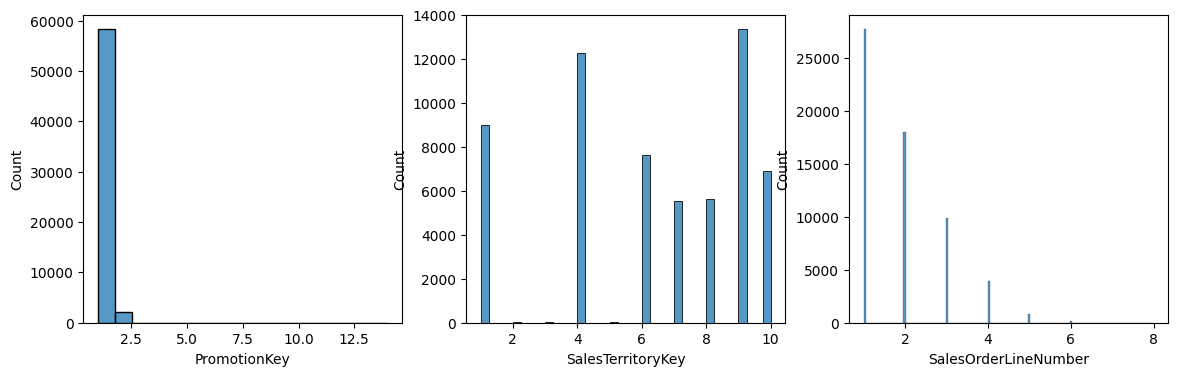

In [10]:
df = sales
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
sns.histplot(ax=axes[0], x=df['PromotionKey'])
sns.histplot(ax=axes[1], x=df['SalesTerritoryKey'])
sns.histplot(ax=axes[2], x=df['SalesOrderLineNumber']);

* Finalmente, concluimos con 9 columnas menos.
* Obtenemos el tipo de dato y número de caracteres de las columnas.
* Se identifican 5 llaves que contienen "Key" en su nombre.

In [6]:
num_types = sales.dtypes.to_frame('dtypes')
col_len = sales.astype(str).apply(lambda s: s.str.len()).max().to_frame('length')
pd.concat([num_types, col_len], axis=1)

,dtypes,length
ProductKey,int64,3
CustomerKey,int64,5
PromotionKey,int64,2
CurrencyKey,int64,3
SalesTerritoryKey,int64,2
SalesOrderNumber,object,7
SalesOrderLineNumber,int64,1
UnitPrice,float64,9
ExtendedAmount,float64,9
ProductStandardCost,float64,9
